## Assigment 2
This code was writen by Polina Turishcheva, Fall 2020 

Task description - https://hackmd.io/SEO45zLkQ3-B3nMZPUhKYw?view

The function that outputs ```predictions.csv``` is at the end of this notebook, named ```made_output()``` - pass it the path to the folder with test images and it will return ```predictions.csv``` in the current directory (the one you run code from)

## Autoencoder trained on both positive and negative cases

In [2]:
import torch
import cv2
from os import listdir
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset, TensorDataset, random_split
from tqdm.notebook import tqdm

In [4]:
# !ls

In [ ]:
# !unzip Dataset.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: __MACOSX/Dataset/Negative/._12703.jpg  
  inflating: Dataset/Negative/02510.jpg  
  inflating: __MACOSX/Dataset/Negative/._02510.jpg  
  inflating: Dataset/Negative/16565.jpg  
  inflating: __MACOSX/Dataset/Negative/._16565.jpg  
  inflating: Dataset/Negative/01019.jpg  
  inflating: __MACOSX/Dataset/Negative/._01019.jpg  
  inflating: Dataset/Negative/08983.jpg  
  inflating: __MACOSX/Dataset/Negative/._08983.jpg  
  inflating: Dataset/Negative/06776.jpg  
  inflating: __MACOSX/Dataset/Negative/._06776.jpg  
  inflating: Dataset/Negative/09445.jpg  
  inflating: __MACOSX/Dataset/Negative/._09445.jpg  
  inflating: Dataset/Negative/07468.jpg  
  inflating: __MACOSX/Dataset/Negative/._07468.jpg  
  inflating: Dataset/Negative/10114.jpg  
  inflating: __MACOSX/Dataset/Negative/._10114.jpg  
  inflating: Dataset/Negative/18548.jpg  
  inflating: __MACOSX/Dataset/Negative/._18548.jpg  
  inflating: Dataset/Neg

In [5]:
positive = listdir("Dataset/Positive")
positive = [f"Dataset/Positive/{i}" for i in positive]
negative = listdir("Dataset/Negative")
negative = [f"Dataset/Negative/{i}" for i in negative]    

In [6]:
def upload_and_preprosessing(path):
#     images of variable lenth should be allowed (make some preprocessing for that)
#     tranformed to grayscale and to 128x128 size
    return cv2.resize((cv2.imread(path, 0)), (128,128)).astype('float32') / 255.0 

In [56]:
def create_dataset(fnames: list, y_val):
    '''
    Function creates a torch Dataset from a list of file names
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    xs = []
    for fname in fnames:
        xs.append(upload_and_preprosessing(fname))
    
    xs = torch.tensor(xs, device=device, dtype=torch.float32)  
    ys = torch.tensor([y_val]*len(fnames), device=device, dtype=torch.long)

    return TensorDataset(xs, ys)  

def create_final_dataset(positive_ways, negative_ways, perc =0.8):
    l = int((len(positive_ways)+len(negative_ways))*perc)
    pos_dataset = create_dataset(positive_ways, 1)
    neg_dataset = create_dataset(negative_ways, 0)
    return random_split(ConcatDataset([pos_dataset, neg_dataset]), [l, (len(positive_ways)+len(negative_ways))-l]) 

In [8]:
# inspired by https://arxiv.org/pdf/1802.02208.pdf

class Autoncoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.features = nn.Sequential(
#             encoder part
            nn.Conv2d(1, 8, 3, stride= 1, padding=1),
            nn.ELU(),
            nn.Conv2d(8, 8, 3, stride= 1, padding=1),
            nn.ELU(),
            nn.MaxPool2d(2, stride=2, padding=0),

            nn.Conv2d(8, 16, 3, stride= 1, padding=1),
            nn.ELU(),
            nn.Conv2d(16, 16, 3, stride= 1, padding=1),
            nn.ELU(),
            nn.MaxPool2d(2, stride=2, padding=0),

            nn.Conv2d(16, 32, 3, stride= 1, padding=1),
            nn.ELU(),
            nn.Conv2d(32, 32, 3, stride= 1, padding=1),
            nn.ELU(),
            nn.MaxPool2d(2, stride=2, padding=0),

            nn.Conv2d(32, 64, 3, stride= 1, padding=1),
            nn.ELU(),
            nn.Conv2d(64, 64, 3, stride= 1, padding=1),
            nn.ELU(),
            nn.MaxPool2d(16, stride=2, padding=0),
            
            
            
#             decoder part
            nn.UpsamplingNearest2d(16),
            nn.ELU(),
            nn.ConvTranspose2d(64, 64, 3, stride= 1, padding=1),
            nn.ELU(),
            nn.ConvTranspose2d(64, 32, 3, stride= 1, padding=1),

            nn.UpsamplingNearest2d(32),
            nn.ELU(),
            nn.ConvTranspose2d(32, 32, 3, stride= 1, padding=1),
            nn.ELU(),
            nn.ConvTranspose2d(32, 16, 3, stride= 1, padding=1),

            nn.UpsamplingNearest2d(64),
            nn.ELU(),
            nn.ConvTranspose2d(16, 16, 3, stride= 1, padding=1),
            nn.ELU(),
            nn.ConvTranspose2d(16, 8, 3, stride= 1, padding=1),

            nn.UpsamplingNearest2d(128),
            nn.ELU(),
            nn.ConvTranspose2d(8, 8, 3, stride= 1, padding=1),
            nn.ELU(),
            nn.ConvTranspose2d(8, 1, 3, stride= 1, padding=1),
        )
        

    def forward(self, x):
        return self.features(x)

In [11]:
def train_loop(dl, model, saving_name, epochs):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  losses = []
  minibatch_losses = []
  criterion = nn.MSELoss()

  for epoch in range(epochs):
    
    loss = 0.0
    model.train()
    minibatch_counter = 0
    
    for x, _ in tqdm(dl):
        x = x.cuda()
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        x = torch.unsqueeze(x, 1)
        # compute reconstructions
        outputs = model.forward(x)

        # compute training reconstruction loss
        train_loss = criterion(outputs, x)

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        item = train_loss.item()
        loss += item
        minibatch_losses.append(item)
        minibatch_counter += 1
        
    # compute the epoch training loss
    loss = loss / minibatch_counter # loss per batch
    losses.append(item)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}, f"{saving_name}{epoch}.pt")
  
  return minibatch_losses, losses

In [15]:
# dataset loading may execute a couple of minutes
my_dataset = create_final_dataset(positive, negative)
dl = DataLoader(my_dataset[0], shuffle=True, batch_size=128)

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = Autoncoder()

In [ ]:
minibatch_losses, losses = train_loop(dl, model, saving_name='day2-both-stage', epochs=10)


epoch : 1/10, loss = 0.028373



epoch : 2/10, loss = 0.017535



epoch : 3/10, loss = 0.011033



epoch : 4/10, loss = 0.008685



epoch : 5/10, loss = 0.008614



epoch : 6/10, loss = 0.008557



epoch : 7/10, loss = 0.008504



epoch : 8/10, loss = 0.008497



epoch : 9/10, loss = 0.008428



epoch : 10/10, loss = 0.008368


Text(0.5, 0, 'Minibatch Number')

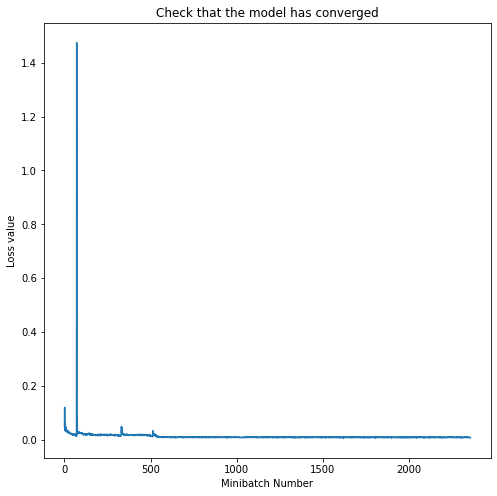

In [ ]:
plt.figure(figsize=(8,8))
d = np.array(minibatch_losses)
plt.plot(range(len(minibatch_losses)), d)
plt.title("Check that the model has converged")
plt.ylabel("Loss value")
plt.xlabel("Minibatch Number")

## Predict and check losses

* predict the train set losses, visualize set and set a threshold





In [47]:
def load_preprained(name):
  pretrained_weights = torch.load(name)['model_state_dict']
  loaded = Autoncoder()
  loaded.load_state_dict(pretrained_weights)
  loaded.to('cuda')
  return loaded

def evaluate_dataset(model, ds, batch_size=1):
  dl = DataLoader(ds, shuffle=True, batch_size=batch_size)

  labels_true = []
  losses = []
  model.eval()

  criterion = nn.MSELoss()
  with torch.no_grad():
    for x, y in tqdm(dl):
        labels_true.append(y)
        x = x.cuda()
        x = torch.unsqueeze(x, 1)
        output = model(x)
              
        loss = criterion(output, x).item()
        losses.append(loss)
  labels_true = torch.cat(labels_true, dim=-1).tolist()

  return np.array(losses), np.array(labels_true)

In [ ]:
model_loaded = load_preprained('day2-both-stage9.pt')
losses, labels_true = evaluate_dataset(model_loaded, my_dataset[0])

In [ ]:
def get_label_losses(losses, labels):
  negative_losses = losses[labels == 0]
  positive_losses = losses[labels == 1]
  return negative_losses, positive_losses

In [ ]:
negative_losses, positive_losses = get_label_losses(losses, labels_true)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


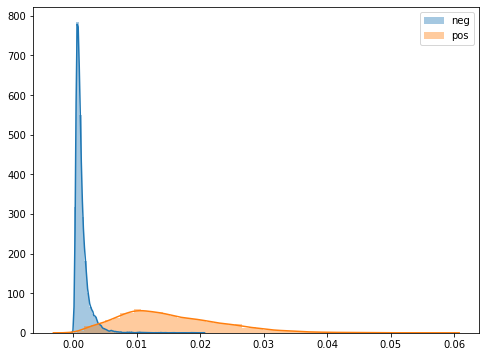

In [ ]:
import seaborn as sns
plt.figure(figsize = (8,6))
sns.distplot(negative_losses, label="neg")
sns.distplot(positive_losses, label="pos")
plt.legend()

(0.0, 60.0)

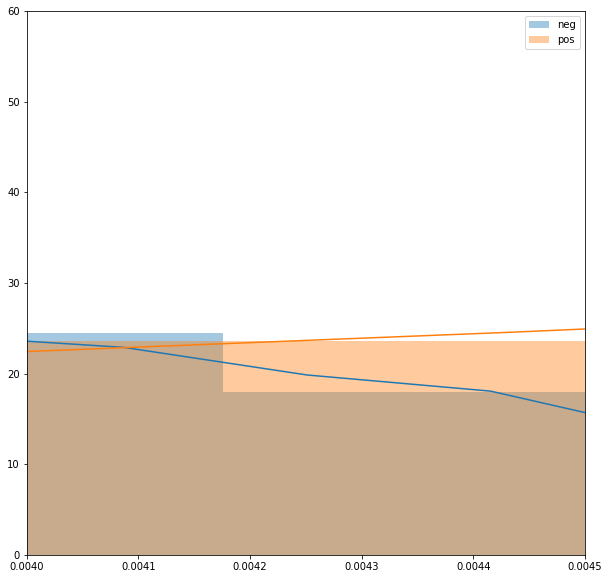

In [ ]:
plt.figure(figsize = (10,10))
sns.distplot(negative_losses, label ="neg")
sns.distplot(positive_losses, label ="pos")
plt.legend()
plt.xlim(0.004, 0.0045)
plt.ylim(0,60)

In [ ]:
threshold_both = 0.0041

## Check the selected threshold on the test set

In [101]:
from sklearn.metrics import precision_score, recall_score, precision_score, confusion_matrix, f1_score

def check_performance_on_testset(model, test_dataset, tr=0.01):
  losses, labels_true = evaluate_dataset(model, test_dataset)
  thr_predictions = np.where(losses>tr, 1, 0)
  print(f'PRECISION {precision_score(labels_true, thr_predictions)}')
  print(f'RECALL {recall_score(labels_true, thr_predictions)}')
  print(f'PRECISION {precision_score(labels_true, thr_predictions)}')
  print(f'CONFUSION MATRIX {confusion_matrix(labels_true, thr_predictions)}')
  print(f'F1 SCORE : {f1_score(labels_true, thr_predictions)}')

In [ ]:
check_performance_on_testset(model_loaded, test_dataset=my_dataset[1], tr=threshold_both)  


PRECISION 0.959880726484142
RECALL 0.9467914438502674
PRECISION 0.959880726484142
CONFUSION MATRIX [[3654  148]
 [ 199 3541]]
F1 SCORE : 0.9532911562794455


## Train Autoencoder on only positive examples

* Originally autoencoders are supposed to be ubsed in anomaly detection in case on unclear anomalies and in imbalanced datasets, therefore, lets make our dataset artificially inbalanced training on only examples without cracks

In [ ]:
def create_positive_dataset(positive_ways, perc =0.8):
    l = int(len(positive_ways)*perc)
    pos_dataset = create_dataset(positive_ways, 1)
    return random_split(pos_dataset, [l, (len(positive_ways)-l)]) 

In [ ]:
#  this may execute a couple of minutes
model_pos = Autoncoder()
positive_only= create_positive_dataset(positive)
dl = DataLoader(positive_only[0], shuffle=True, batch_size=128)

In [ ]:
minibatch_losses, losses = train_loop(dl, model_pos, saving_name='day2-only-positive-stage', epochs=10)


epoch : 1/10, loss = 0.022236



epoch : 2/10, loss = 0.016023



epoch : 3/10, loss = 0.015098



epoch : 4/10, loss = 0.014824



epoch : 5/10, loss = 0.014552



epoch : 6/10, loss = 0.014141



epoch : 7/10, loss = 0.013917



epoch : 8/10, loss = 0.013779



epoch : 9/10, loss = 0.013648



epoch : 10/10, loss = 0.013512


## Select threshold

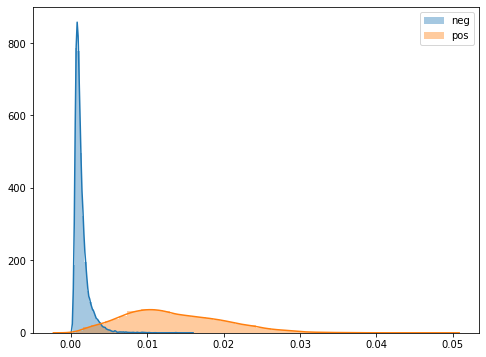

In [ ]:
model_loaded = load_preprained('day2-only-positive-stage9.pt')
losses, labels_true = evaluate_dataset(model_loaded, my_dataset[0])
negative_losses, positive_losses = get_label_losses(losses, labels_true)

plt.figure(figsize = (8,6))
sns.distplot(negative_losses, label="neg")
sns.distplot(positive_losses, label="pos")
plt.legend()

(0.0, 60.0)

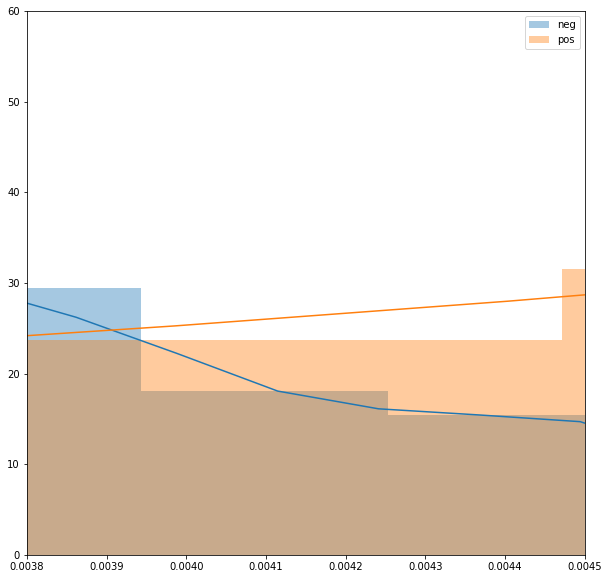

In [ ]:
plt.figure(figsize = (10,10))
sns.distplot(negative_losses, label ="neg")
sns.distplot(positive_losses, label ="pos")
plt.legend()
plt.xlim(0.0038, 0.0045)
plt.ylim(0,60)

## Check the selected threshold on the test set (the same as the previous one)

In [ ]:
check_performance_on_testset(model_loaded, test_dataset=my_dataset[1], tr=0.0039)  


PRECISION 0.964110929853181
RECALL 0.9481283422459893
PRECISION 0.964110929853181
CONFUSION MATRIX [[3670  132]
 [ 194 3546]]
F1 SCORE : 0.9560528444324615


* Training only positive example does not give any results improvement

## Train Autoencoder on only negative examples

In [ ]:
model_neg = Autoncoder()
negative_only= create_positive_dataset(negative)
dl = DataLoader(negative_only[0], shuffle=True, batch_size=128)

In [ ]:
minibatch_losses, losses = train_loop(dl, model_neg, saving_name='day2-only-negative-stage', epochs=10)


epoch : 1/10, loss = 0.047647



epoch : 2/10, loss = 0.007065



epoch : 3/10, loss = 0.002587



epoch : 4/10, loss = 0.002094



epoch : 5/10, loss = 0.002085



epoch : 6/10, loss = 0.001758



epoch : 7/10, loss = 0.001644



epoch : 8/10, loss = 0.003208



epoch : 9/10, loss = 0.001585



epoch : 10/10, loss = 0.001487


## Select threshold

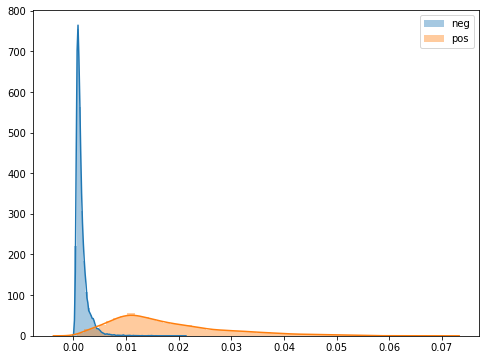

In [ ]:
model_loaded_neg = load_preprained('day2-only-negative-stage9.pt')
losses, labels_true = evaluate_dataset(model_loaded_neg, my_dataset[0])
negative_losses, positive_losses = get_label_losses(losses, labels_true)

plt.figure(figsize = (8,6))
sns.distplot(negative_losses, label="neg")
sns.distplot(positive_losses, label="pos")
plt.legend()

(0.0, 60.0)

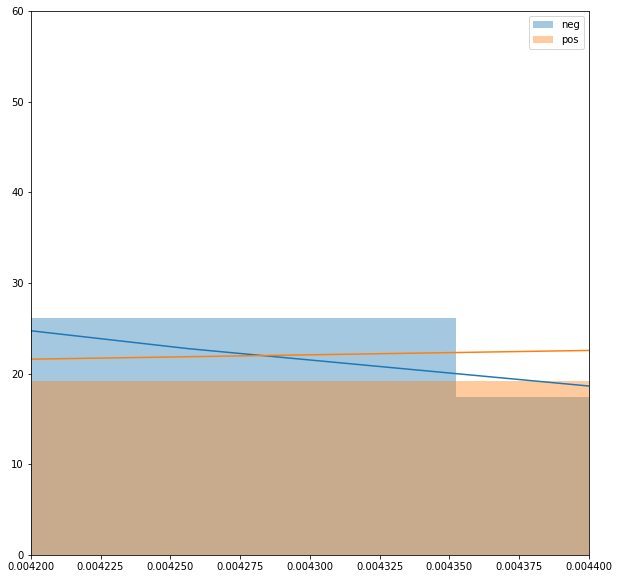

In [ ]:
plt.figure(figsize = (10,10))
sns.distplot(negative_losses, label ="neg")
sns.distplot(positive_losses, label ="pos")
plt.legend()
plt.xlim(0.0042, 0.0044)
plt.ylim(0,60)

## Check the selected threshold on the test set (the same as the previous one)


In [ ]:
check_performance_on_testset(model_loaded_neg, test_dataset=my_dataset[1], tr=0.00425)  


PRECISION 0.9558308645300296
RECALL 0.9489304812834225
PRECISION 0.9558308645300296
CONFUSION MATRIX [[3638  164]
 [ 191 3549]]
F1 SCORE : 0.9523681738897087


* Training on only negative examples has also given no improvement

## Classifier 

In [65]:
# inspired by https://arxiv.org/pdf/1802.02208.pdf

class Classifier(nn.Module):
    def __init__(self, **kwargs):
        super(Classifier, self).__init__(**kwargs)
        self.features = nn.Sequential(
#             encoder part
            nn.Conv2d(1, 8, 3, stride= 1, padding=1),
            nn.ELU(),
            nn.Conv2d(8, 8, 3, stride= 1, padding=1),
            nn.ELU(),
            nn.MaxPool2d(2, stride=2, padding=0),

            nn.Conv2d(8, 16, 3, stride= 1, padding=1),
            nn.ELU(),
            nn.Conv2d(16, 16, 3, stride= 1, padding=1),
            nn.ELU(),
            nn.MaxPool2d(2, stride=2, padding=0),

            nn.Conv2d(16, 32, 3, stride= 1, padding=1),
            nn.ELU(),
            nn.Conv2d(32, 32, 3, stride= 1, padding=1),
            nn.ELU(),
            nn.MaxPool2d(2, stride=2, padding=0),

            nn.Conv2d(32, 64, 3, stride= 1, padding=1),
            nn.ELU(),
            nn.Conv2d(64, 64, 3, stride= 1, padding=1),
            nn.ELU(),
            nn.MaxPool2d(2, stride=2, padding=0),
            nn.Flatten()
        )

        self.classifier = nn.Sequential(
            nn.Linear(64*64, 64*64),
            nn.LeakyReLU(),
            nn.Linear(64*64, 16*64),
            nn.LeakyReLU(),
            nn.Linear(16*64, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        

    def forward(self, x):
        return self.classifier(self.features(x))

In [68]:
def train_loop_clas(dl, model, saving_name, epochs):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(device)
  model.to(device)
  
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  losses = []
  minibatch_losses = []
  criterion = nn.BCELoss()

  for epoch in range(epochs):
    
    loss = 0.0
    model.train()
    minibatch_counter = 0
    
    for x, y in tqdm(dl):
        x,y = x.cuda(), y.cuda()
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        x = torch.unsqueeze(x, 1)
        # compute reconstructions
        outputs = model.forward(x)

        # compute training reconstruction loss
        train_loss = criterion(outputs, torch.reshape(y, (y.size()[0], 1)))

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        item = train_loss.item()
        loss += item
        minibatch_losses.append(item)
        minibatch_counter += 1
        
    # compute the epoch training loss
    loss = loss / minibatch_counter # loss per batch
    losses.append(item)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}, f"{saving_name}{epoch}.pt")
  
  return minibatch_losses, losses

In [123]:
model_clas = Classifier()
dl = DataLoader(my_dataset[0], shuffle=True, batch_size=128)
minibatch_losses, losses = train_loop_clas(dl, model_clas, 'classifier-try3-', epochs=10)

cuda



epoch : 1/10, loss = 0.355778



epoch : 2/10, loss = 0.023547



epoch : 3/10, loss = 0.022272



epoch : 4/10, loss = 0.017007



epoch : 5/10, loss = 0.014364



epoch : 6/10, loss = 0.011449



epoch : 7/10, loss = 0.009645



epoch : 8/10, loss = 0.006662



epoch : 9/10, loss = 0.007336



epoch : 10/10, loss = 0.006626


## Check the classifier performance



In [108]:
def evaluate_classifier(model, ds, batch_size=1):
  dl = DataLoader(ds, shuffle=True, batch_size=batch_size)
  labels_true = []
  predictions = []
  model.eval()
  with torch.no_grad():
    for x, y in tqdm(dl):
        labels_true.append(y)
        x = x.cuda()
        x = torch.unsqueeze(x, 1)
        output = model(x).item()
        predictions.append(output)
               
  labels_true = torch.cat(labels_true, dim=-1).tolist()
  predictions = [round(i) for i in predictions]

  return np.array(predictions), np.array(labels_true)

In [121]:
pretrained_weights = torch.load('classifier-try215.pt')['model_state_dict']
loaded = Classifier()
loaded.load_state_dict(pretrained_weights)
loaded.to('cuda')
predictions, labels_true = evaluate_classifier(loaded, my_dataset[1], batch_size=1)

In [122]:
print(f'PRECISION {precision_score(labels_true, predictions)}')
print(f'RECALL {recall_score(labels_true, predictions)}')
print(f'PRECISION {precision_score(labels_true, predictions)}')
print(f'CONFUSION MATRIX {confusion_matrix(labels_true, predictions)}')
print(f'F1 SCORE : {f1_score(labels_true, predictions)}')

PRECISION 0.9989420788151283
RECALL 0.990558615263572
PRECISION 0.9989420788151283
CONFUSION MATRIX [[3725    4]
 [  36 3777]]
F1 SCORE : 0.9947326836976561


* Classifier shows rather better results compared to autoencoders

## Desired output

In [126]:
import pandas as pd
from os import walk, path

In [163]:
def make_output(path_to_dir, mode='classifier', tr=0.0041):
  '''
  mode='classifier' -> take and predict classifier model
  mode='autoencoder' -> take and predict autoencoder model
  '''

  list_of_path = []
  for p, subdirs, files in walk("Dataset/"):
    for name in files:
        list_of_path.append(path.join(p, name))

  res = pd.DataFrame(list_of_path)
  res['label'] = 0
  
  predictions = []
  if mode=='classifier':
    pretrained_weights = torch.load('classifier-try215.pt')['model_state_dict']
    loaded = Classifier()
    loaded.load_state_dict(pretrained_weights)
    loaded.to('cuda')
    loaded.eval()
    with torch.no_grad():
      for i in tqdm(list_of_path):
        x = torch.tensor(upload_and_preprosessing(i),  device='cuda')
        x = torch.unsqueeze(x, 0)
        x = torch.unsqueeze(x, 0)
        output = loaded(x).item()
        predictions.append(output)
               
    predictions = [round(i) for i in predictions]

  else:
    pretrained_weights = torch.load('day2-both-stage9.pt')['model_state_dict']
    to_pred = Autoncoder()
    to_pred.load_state_dict(pretrained_weights)
    to_pred.to('cuda')
    to_pred.eval()

    losses = []
    criterion = nn.MSELoss()
    with torch.no_grad():
      for i in tqdm(list_of_path):

        x = torch.tensor(upload_and_preprosessing(i),  device='cuda')
        x = torch.unsqueeze(x, 0)
        x = torch.unsqueeze(x, 0)
        output = to_pred(x)
              
        loss = criterion(output, x).item()
        losses.append(loss)
        if loss > tr:
          predictions.append(1)
        else:
          predictions.append(0)

  res['label']=predictions
  res.to_csv('predictions.csv')